# **Anomaly Detection [Outliers Detection]**

**Introduction:**

Anomaly detection is a process where you find out the list of outliers from your data. An outlier is a sample that has inconsistent data compared to other regular samples hence raises suspicion on their validity. The presence of outliers can also impact the performance of machine learning algorithms when performing supervised tasks. It can also interfere with data scaling which is a common data preprocessing step. As a part of this tutorial, we'll be discussing estimators available in scikit-learn which can help with identifying outliers from data.

Below is a list of scikit-learn estimators which let us identify outliers present in data that we'll be discussing as a part of this tutorial:

 - KernelDensity
 - OneClassSVM
 = IsolationForest
 - LocalOutlierFactor
 
We'll be explaining the usage of each one with various examples.

Let’s start by importing the necessary libraries.

In [ ]:
!git clone https://github.com/hussain0048/Machine-Learning.git

# **Importing necessary libraries** #

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# **Load Datasets**
We'll start by loading two datasets that we'll be using for our explanation purpose.

- Blobs Dataset - We have created a blobs dataset which has data of 3 clusters with 500 samples and 2 features per sample. We'll be using this dataset primarily for an explanation of sklearn estimators.
- Digits Dataset - The second dataset that we'll load is digits dataset which has 1797 images of 0-9 digits. Each image is of size 8x8 which is flattened and kept as an array of size 64.


In [3]:
 from sklearn.datasets import make_blobs

X, Y = make_blobs(n_features=2, centers=3, n_samples=500,
                  random_state=42)

print("Dataset Size : ", X.shape, Y.shape)

Dataset Size :  (500, 2) (500,)


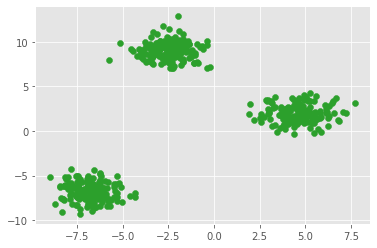

In [4]:
with plt.style.context("ggplot"):
    plt.scatter(X[:, 0], X[:, 1], c="tab:green")

In [5]:
from sklearn.datasets import load_digits

digits = load_digits()

X_digits, Y_digits = digits.data, digits.target

print("Dataset Size : ", X_digits.shape, Y_digits.shape)

Dataset Size :  (1797, 64) (1797,)


# 1- **KernelDensity** 
The KernelDensity estimator is available as a part of the kde module of the neighbors module of sklearn. It helps us measure kernel density of samples which can be then used to take out outliers. It uses KDTree or BallTree algorithm for kernel density estimation.

Below is a list of important parameters of KernelDensity estimator:

- algorithm - It accepts string value specifying which algorithm to use for kernel density estimation. We can specify one of the below values for this parameter.
  - auto - Default.
  - kd_tree
  - ball_tree
- kernel - It accepts string which let us specify which kernel to use for estimation. We can specify one of the below values.
  - gaussian
  - tophat
  - epanechnikov
  - exponential
  - linear
  - cosine

## 1.1  Fitting Model to Data

We'll first fit the KernelDensity estimator to our dataset using fit() method of it and then use it for finding out outliers

In [ ]:
from sklearn.neighbors.kde import KernelDensity
# Estimate density with a Gaussian kernel density estimator
kde = KernelDensity(kernel='gaussian')
kde.fit(X)

## 1.2 - Calculate Log Density Evaluations for Each Sample
The KernelDensity estimator has a method named score_samples() which accepts dataset and returns log density evaluations for each sample of data. We'll divide these values into 95% as valid data and 5% as outliers based on the output of score_samples() function.

In [7]:
kde_X = kde.score_samples(X)
kde_X[:5]  # contains the log-likelihood of the data. The smaller it is the rarer is the sample

array([-4.08546941, -5.33064441, -4.97908884, -4.18442233, -4.03465512])

## 1.3-Dividing Dataset into Valid Samples and Outliers
Below we are trying to find out quantiles value for 5% of total data. We'll use that value to divide data into outliers and valid samples

In [ ]:
from scipy.stats.mstats import mquantiles

alpha_set = 0.95
tau_kde = mquantiles(kde_X, 1. - alpha_set)

tau_kde

All the values in kde_X array which are less than tau_kde will be outliers and values greater than it will be qualified as valid samples. We'll try to find out indexes of samples that are outliers and valid. We'll then use these indexes to filter data to divide it into outliers and valid samples.

In [ ]:
outliers = np.argwhere(kde_X < tau_kde)
outliers = outliers.flatten()
X_outliers = X[outliers]

normal_samples = np.argwhere(kde_X >= tau_kde)
normal_samples = normal_samples.flatten()
X_valid = X[normal_samples]

print("Original Samples : ",X.shape[0])
print("Number of Outliers : ", len(outliers))
print("Number of Normal Samples : ", len(normal_samples))

## 1.4 -Plot Outliers with Valid Samples for Comparison
We have designed the method below named plot_outliers_with_valid_samples which takes as input valid samples and outliers and then plots them using different colors to differentiate between them. The figure will give a better idea about the performance of KernelDensity.


In [10]:
def plot_outliers_with_valid_samples(X_valid, X_outliers):
    with plt.style.context(("seaborn", "ggplot")):
        plt.scatter(X_valid[:, 0], X_valid[:, 1], c="tab:green", label="Valid Samples")
        plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="tab:red", label="Outliers")
        plt.legend(loc="best")

In [ ]:
plot_outliers_with_valid_samples(X_valid, X_outliers)

#2 OneClassSVM 

The OneClassSVM estimator is available as a part of svm module of sklearn. It's based on the SVM algorithm which is used behind the scene to make a decision about the sample is outlier or not.

Below is a list of important parameters of OneClasSVM which can be tweaked further to get better results:

 - kernel - It specifies the kernel type to be used for SVM. It accepts one of the below values as input.
   - linear
   - poly
   - rbf
   - sigmoid
   - precomputed
 - degree - It accepts integer specifying degree of polynomial kernel (kernel='poly'). It's ignored when other kernels are used.
 - gamma - It specifies kernel coefficient to use for rbf, poly and sigmoid kernels. It accepts one of the below string or float as input.
  - scale - It uses 1 / (n_features * X.var()) as value of gamma.
  - auto - Default. It uses 1 / n_features as the value of gamma.
 - nu - It accepts float value in the range (0, 1] specifying upper bound on the fraction of training errors and lower bound on the fraction of support vectors.
 - cache_size - It specifies kernel cache size in MB. It accepts integer values as input. The default value is 200 MB. It’s recommended using more value for bigger datasets for better performance.

## 2.1 Fitting Model to Data¶
We'll now fit OneClassSVM to our Gaussian blobs dataset. We'll then use the trained model to make predictions about samples to let us know whether the sample is an outlier or not.

In [ ]:
from sklearn.svm import OneClassSVM

nu = 0.05  # theory says it should be an upper bound of the fraction of outliers
ocsvm = OneClassSVM(kernel='rbf', gamma=0.05, nu=nu)
ocsvm.fit(X)

## 2.2-Predict Sample Class (Outlier vs Normal)¶

OneClassSVM provides predict() method which accepts samples and returns array consisting of values 1 or -1. Here 1 represents a valid sample and -1 represents an outlier.


In [ ]:
preds = ocsvm.predict(X)
preds[:10]

## 2.3 - Dividing Dataset into Valid Samples and Outliers

We'll now filter original data and divide it into two categories.

- Valid Samples
= Outliers
We'll also print the size of samples that were considered outliers by model.

In [ ]:
X_outliers = X[preds == -1]
X_valid = X[preds != -1]

print("Original Samples : ",X.shape[0])
print("Number of Outliers : ", X_outliers.shape[0])
print("Number of Normal Samples : ", X_valid.shape[0])

## 2.4 Plot Outliers with Valid Samples for Comparison

In [ ]:
plot_outliers_with_valid_samples(X_valid, X_outliers)

## 2.5 Important Attributes and methods of OneClassSVM
Below is a list of important attributes and methods of OneClassSVM which can be used once the model is trained to get meaningful insights.

- support_ - It returns indices of support vectors.
- support_vectors_ - It returns actual support vectors of SVM.
dual_coef_ - It represents coefficients of support vectors in decision function.
- coef_ - It returns an array of the same size as that of features in dataset representing weights assigned to each feature. It works only when kernel linear is used.
- intercept_ - It returns single float value representing intercept when using linear kernel.
- decision_function(X) - It accepts dataset as input and returns signed distance for each sample of data. If the distance is positive then the sample is valid and outlier if negative.


In [ ]:
print("Support Indices : ",ocsvm.support_)

In [ ]:
print("Support Vector Sizes : ", ocsvm.support_vectors_.shape)
ocsvm.support_vectors_[:5]

In [ ]:
print("Dual Coef Size ", ocsvm.dual_coef_.shape)
ocsvm.dual_coef_[0][:5]

In [ ]:
ocsvm_X = ocsvm.decision_function(X)

X_outliers = X[ocsvm_X < 0]
X_valid = X[ocsvm_X > 0]

print("Number of Outliers : ", X_outliers.shape[0])
print("Number of Normal Samples : ", X_valid.shape[0])

ocsvm_X[:10]

We can notice from the above output that decision_function() can be used to find out outliers as well and it'll return the same indexes as predict() for samples which are outliers.

## 2.6-Trying OneClassSVM on DIGITS Dataset.
We are now trying OneClassSVM on the digits dataset. We'll fit it to digits data and then use it to predict whether a sample is an outlier or not

## 2.7 Fitting Model to Data


In [ ]:
 nu = 0.05  # theory says it should be an upper bound of the fraction of outliers
ocsvm = OneClassSVM(kernel='rbf', gamma=0.05, nu=nu)
ocsvm.fit(X_digits)

## 2.8- Predict Sample Class (Outlier vs Normal)


In [ ]:
preds = ocsvm.predict(X_digits)
preds[:10]


## 2.9 -Dividing Dataset into Valid Samples and Outliers

In [ ]:
X_outliers = X_digits[preds == -1]
X_valid = X_digits[preds != -1]
print("Original Samples : ",X_digits.shape[0])
print("Number of Outliers : ", X_outliers.shape[0])
print("Number of Normal Samples : ", X_valid.shape[0])

## 2.10. Plot Few Valid and Outlier Samples 
We'll now plot a few valid samples and few outliers for digits dataset.


In [ ]:
def plot_few_outliers(X_outliers):
    outliers = []
    for x in X_outliers[:10]:
        outliers.append(x.reshape(8,8))

    fig = plt.figure(figsize=(10,4))
    plt.imshow(np.hstack(outliers), cmap="Blues");

plot_few_outliers(X_outliers)

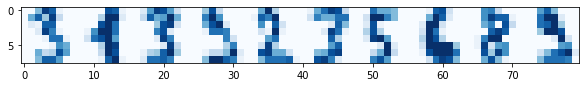

In [24]:
def plot_few_valid_samples(X_valid):
    valid_samples = []
    for x in X_valid[:10]:
        valid_samples.append(x.reshape(8,8))

    fig = plt.figure(figsize=(10,4))
    plt.imshow(np.hstack(valid_samples), cmap="Blues");

plot_few_valid_samples(X_valid)

#3- IsolationForest

IsolationForest is another estimator available as a part of the ensemble module of sklearn which can be used for anomaly detection. It measures the anomaly scores for each sample based on the isolation forest algorithm. IsolationForest isolates samples by randomly selecting a feature of the sample and then randomly selecting a split value between maximum and minimum of the selected sample. It recursively partitions samples based on features that can be represented as tree structures. This results in a number of splittings required to isolate the sample are equal to path length in a tree. This path length can be used to make a decision about the sample being normal or an outlier. Outliers generally have short path lengths.

Below is a list of important attributes of IsolationForest which can be tweaked for better performance:

n_estimators - It accepts integer representing number of base estimators to use for IsolationForest. default=100
max_samples - It represents a number of samples to draw from the dataset to train each base estimator. It accepts the below-mentioned values.
auto - Default. It takes min(256, n_samples) as value of max_samples.
int - We can specify integer value specifying the number of samples.
float - We can specify float value between 0-1 and it'll take that fraction of samples from original data for training.
contamination - It specifies the number of outliers in the dataset. It accepts one of the below values as input.
auto - Default. The value for the number of outliers from the original dataset is determined automatically.
float - It let us specify float value between 0-0.5 and set that many proportions of samples as outliers.

## 3.1 - Fitting Model to Data
We'll now fit IsolationForest to our Gaussian blobs dataset. We'll then use the trained model to make predictions about samples to let us know whether sample is an outlier or not.  

In [ ]:
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(n_estimators=300, contamination=0.05)
iforest.fit(X)

## 3.2 Predict Sample Class (Outlier vs Normal)¶
IsolationForest provides predict() method which accepts samples and returns array consisting of values 1 or -1. Here 1 represents a valid sample and -1 represents an outlier.



In [ ]:
preds = iforest.predict(X)
preds[:10]

## 3.3 -Dividing Dataset into Valid Samples and Outliers

In [ ]:
X_outliers = X[preds == -1]
X_valid = X[preds != -1]
print("Original Samples : ",X.shape[0])
print("Number of Outliers : ", X_outliers.shape[0])
print("Number of Normal Samples : ", X_valid.shape[0])

## 3.4 Plot Outliers with Valid Samples for Comparison¶

In [ ]:
plot_outliers_with_valid_samples(X_valid, X_outliers)


## 3.5 Important Attributes and Methods of IsolationForest

Below is a list of important attributes and methods of IsolationForest which can be used once the model is trained to get meaningful insights.

- estimators_ - It returns a list of base estimators that were trained during training.
- threshold_ - It returns threshold value which will be used to make a decision about the sample is an outlier or not.
- decision_function(X) - It takes dataset as input and returns average anomaly score for each feature. We can then divide the dataset into normal and outliers based on the threshold_ attribute and these parameter values.

In [ ]:
iforest.estimators_[:2]


In [ ]:
iforest.threshold_


Below we are splitting the dataset into valid samples and outliers using output of decision_function() and threshold_ value found out after training model.

In [ ]:
results = iforest.decision_function(X)

outliers  = X[results < iforest.threshold_]
valid_samples = X[results >= iforest.threshold_]

print("Number of Outliers : ", outliers.shape[0])
print("Number of Valid Samples : ", valid_samples.shape[0])

##3.6.Trying IsolationForest on DIGITS Dataset.

In [ ]:
plot_confusion_matrix(Y_test, complement_nb_grid.best_estimator_.predict(X_test))

##3.7 Fitting Default Model To Train Data

In [ ]:
iforest = IsolationForest(n_estimators=300, contamination=0.05)
iforest.fit(X_digits)

##3.8 Predict Sample Class (Outlier vs Normal)

In [ ]:
preds = iforest.predict(X_digits)
preds[:10]

##3.9 Dividing Dataset into Valid Samples and Outliers

In [37]:
 X_outliers = X_digits[preds == -1]
X_valid = X_digits[preds != -1]

print("Original Samples : ",X_digits.shape[0])
print("Number of Outliers : ", X_outliers.shape[0])
print("Number of Normal Samples : ", X_valid.shape[0])

Original Samples :  1797
Number of Outliers :  90
Number of Normal Samples :  1707


## 3.10 Plot Few Valid and Outlier Samples

In [ ]:
plot_few_outliers(X_outliers)


In [ ]:
plot_few_valid_samples(X_valid)


# 4-LocalOutlierFactor ¶

The LocalOutlierFactor estimator is available as the neighbors module of sklearn which is another estimator that lets us find out whether a sample from the dataset is an outlier or not. It measures the local density of a sample with respect to its neighbors. Based on a comparison between the local density of the sample and its neighbors, the decision is made whether the sample is an outlier or not.

Below is a list of important attributes of IsolationForest which can be tweaked for better performance:

- n_neighbors - It accepts integer value specifying the number of neighbors to use for deciding whether to consider sample outlier or not.
- algorithm - It accepts string value specifying the algorithm to use for nearest neighbors. Below is a list of possible values.
 - auto - Default
 - kd_tree
 - ball_tree
`- brute
- metric - It accepts string or callable function specifying metric to use for distance computation. The default value is minkowski for this parameter. Please refer sklearn docs for list of possible metrics for this parameter.
- contamination - It specifies amount of outliers in the dataset. It accepts one of the below values as input.
auto - Default. The value for the number of outliers from the original dataset is determined automatically.
float - It let us specify float value between 0-0.5 and set that many proportions of samples as outliers.

## 4.1 Fitting a model 
We'll now fit LocalOutlierFactor to our Gaussian blobs dataset. We'll then use the trained model to make predictions about samples to let us know whether the sample is an outlier or not.

In [40]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()

## 4.2 Predict Sample Class (Outlier vs Normal)¶

LocalOutlierFactor provides predict() method which accepts samples and returns array consisting of values 1 or -1. Here 1 represents a valid sample and -1 represents an outlier.

In [ ]:
preds = lof.fit_predict(X)
preds[:10]

## 4.3 Dividing Dataset into Valid Samples and Outliers# 

In [ ]:
X_outliers = X[preds == -1]
X_valid = X[preds != -1]
print("Original Samples : ",X.shape[0])
print("Number of Outliers : ", X_outliers.shape[0])
print("Number of Normal Samples : ", X_valid.shape[0])

## 4.4 Plot Outliers with Valid Samples for Comparison

In [ ]:
plot_outliers_with_valid_samples(X_valid, X_outliers)


## 4.5 Important Attributes and Methods of LocalOutlierFactor
Below is a list of important attributes and methods of LocalOutlierFactor which can be used once the model is trained to get meaningful insights.

- negative_outlier_factor_ - It represents the opposite of LOF of data samples. The higher the value for the sample, the more normal it is.
- offset_ - It specifies a value which can be used as a threshold to divide samples into normal or outlier based on negative_outlier_factor_ values of samples

In [ ]:
lof.offset_


In [ ]:
print("Negative Outlier Factor Shape : ", lof.negative_outlier_factor_.shape)


Below we are dividing the dataset into normal and outliers based on offset_ and negative_outlier_factor_ parameters of LocalOutlierFactor. It gives the same result as that of predict()

In [46]:
outliers  = X[lof.negative_outlier_factor_ < lof.offset_]
valid_samples = X[lof.negative_outlier_factor_ >= lof.offset_]

print("Number of Outliers : ", outliers.shape[0])
print("Number of Valid Samples : ", valid_samples.shape[0])

Number of Outliers :  30
Number of Valid Samples :  470


## 4.6 Trying LocalOutlierFactor on DIGITS Dataset

## 4.7  Fitting Model to Data¶


In [ ]:
lof = LocalOutlierFactor(n_neighbors=100)

preds = lof.fit_predict(X_digits)
preds[:10]


## 4.8 Dividing Dataset into Valid Samples and Outliers 

In [ ]:
X_outliers = X_digits[preds == -1]
X_valid = X_digits[preds != -1]

print("Original Samples : ",X_digits.shape[0])
print("Number of Outliers : ", X_outliers.shape[0])
print("Number of Normal Samples : ", X_valid.shape[0])

##4.9 Plot Few Valid and Outlier Samples

In [ ]:
plot_few_outliers(X_outliers)

In [ ]:
plot_few_valid_samples(X_valid)


References:
Scikit-Learn - Anomaly Detection [Outliers Detection]
https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-anomaly-detection-outliers-detection